## Importing Libraries

In [1]:
import pandas as pd
import numpy as np
from datetime import date, timedelta
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
import pypfopt.plotting as plotting
from pypfopt.expected_returns import mean_historical_return
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import discrete_allocation
from pypfopt import expected_returns
from pypfopt import risk_models
from pypfopt import EfficientFrontier
from pypfopt import objective_functions
from pypfopt import base_optimizer
from pypfopt.discrete_allocation import DiscreteAllocation
from pypfopt.hierarchical_portfolio import HRPOpt

## Getting the Data

In [2]:
start_date = date(2022, 1, 1)
end_date = date(2022, 12, 31)

# Define the ticker list
tickers_list = ['AAPL', 'WMT', 'MU', 'BA','GOOG','BABA','GE','AMD','BAC','GM','T','UAA','XOM','RRC','PFE','JPM','SBUX']

# Fetch the data
import yfinance as yf
data = yf.download(tickers_list, start=start_date, end=end_date)['Adj Close']
#print(data.iloc[-1])
# Print first 5 rows of the data
#print(data.head())
#print(data.tail())

[*********************100%***********************]  17 of 17 completed


In [3]:
# Download benchmark data - We can also use Buffet's Portfolio as a Benchmark
spy_data = yf.download('SPY', start=start_date, end=end_date)['Adj Close']

[*********************100%***********************]  1 of 1 completed


## Applying Markowitz

In [4]:
# Prepare historical price data for assets
#historical_prices = pd.read_csv('historical_prices.csv', index_col=0, parse_dates=True)
historical_prices = data


# Calculate expected returns
returns = expected_returns.mean_historical_return(historical_prices)
#Add shrinkage here
#https://pyportfolioopt.readthedocs.io/en/latest/RiskModels.html#pypfopt.risk_models.CovarianceShrinkage
cov_matrix = risk_models.sample_cov(historical_prices)

# Create an instance of EfficientFrontier
ef = EfficientFrontier(returns, cov_matrix,weight_bounds = (0,0.2))

# Efficient Frontier with random portfolios

Maximise the Sharpe Ratio. The result is also referred to as the tangency portfolio, as it is the portfolio for which the capital market line is tangent to the efficient frontier.

This is a convex optimization problem after making a certain variable substitution. See Cornuejols and Tutuncu (2006) for more.

Because max_sharpe() makes a variable substitution, additional objectives may not work as intended.

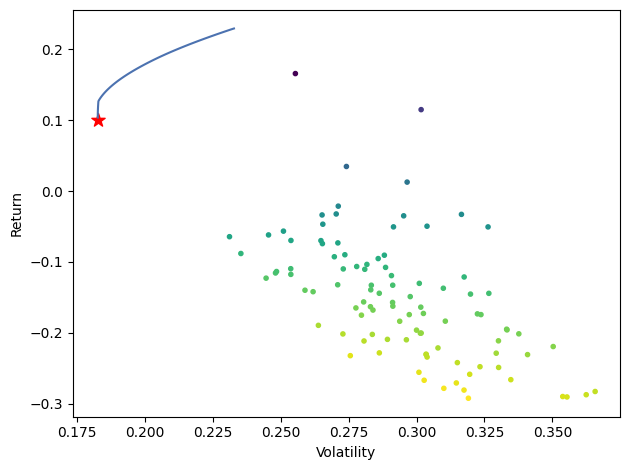

In [5]:
fig, ax = plt.subplots()
ef_optimize = ef.deepcopy()
plotting.plot_efficient_frontier(ef, ax=ax, show_assets=False)

### Choosing Optimization Strategy (Comment out the other approach you want to use)

### adding gamma for diversification - https://pyportfolioopt.readthedocs.io/en/latest/MeanVariance.html#l2-regularisation
#ef_optimize.add_objective(objective_functions.L2_reg, gamma=1.5)


### adding transaction costs objective function - https://github.com/robertmartin8/PyPortfolioOpt/blob/master/cookbook/3-Advanced-Mean-Variance-Optimisation.ipynb
# Pretend that you started with a default-weight allocation
initial_weights = np.array([1/len(tickers_list)] * len(tickers_list))
ef_optimize.add_objective(objective_functions.transaction_cost, w_prev=initial_weights, k=0.001)

#For Min Volatility
ef_optimize.min_volatility()

#For Max Sharpe - 
#max_sharpe transforms the optimization problem so additional objectives eg. transaction costs, gamma may not work as expected.

#ef_optimize.max_sharpe()

# Markowitz with Target Volatility

#target_volatility = 0.2
#ef_optimize.efficient_risk(target_volatility)

# Find the tangency portfolio

ret_tangent, std_tangent, _ = ef_optimize.portfolio_performance()
ax.scatter(std_tangent, ret_tangent, marker="*", s=100, c="r", label="Max Sharpe")

# Generate random portfolios
n_samples = 100
w = np.random.dirichlet(np.ones(ef.n_assets), n_samples)
# Normalize weights to sum up to 1 - to make sure they lie within efficient frontier
w = w / np.sum(w, axis=1, keepdims=True)  
rets = w.dot(ef.expected_returns)
stds = np.sqrt(np.diag(w @ ef.cov_matrix @ w.T))
sharpes = rets / stds
ax.scatter(stds, rets, marker=".", c=sharpes, cmap="viridis_r")

# Output
#ax.set_title("Efficient Frontier with random portfolios")
#ax.legend()
ax.get_legend().remove()
plt.tight_layout()
#Saves the output file as a transparent image
plt.savefig("ef_scatter.png", dpi=200, transparent=True)
plt.show()

In [6]:
# Print Weights - Max Sharpe
cleaned_weights = ef_optimize.clean_weights()
print(cleaned_weights)

OrderedDict([('AAPL', 0.0), ('AMD', 0.0), ('BA', 0.00104), ('BABA', 0.0), ('BAC', 0.00486), ('GE', 0.00343), ('GM', 0.0), ('GOOG', 0.00436), ('JPM', 0.12335), ('MU', 0.0), ('PFE', 0.2), ('RRC', 0.0), ('SBUX', 0.08877), ('T', 0.2), ('UAA', 0.0), ('WMT', 0.2), ('XOM', 0.17419)])


## Portfolio Performance

In [7]:
#to know the expected performance of the portfolio with optimal weights w
ef_optimize.portfolio_performance(verbose=True)

Expected annual return: 10.0%
Annual volatility: 18.3%
Sharpe Ratio: 0.44


(0.10042226160429665, 0.18266165773786505, 0.4402799284768859)

## Comparison with Benchmark Chart

In [8]:
# Create an empty Series to store portfolio returns
portfolio_returns_1 = pd.Series()
portfolio_returns_1.index.name = 'Date'

# Extract unique years
unique_years = historical_prices.index.year.unique()

In [9]:
# Iterate through each year
for year in unique_years:
    
    # Filter the DataFrame for the current year
    current_year_prices = historical_prices[historical_prices.index.year == year]
    # to get the last day of the previous year prices
    previous_year_prices = historical_prices[historical_prices.index.year == year-1]
    # Concatenate the last day of the previous year with the current year's data
    # (to avoid NaN value for the first day of the year)
    current_year_prices = pd.concat([previous_year_prices.tail(1), current_year_prices])
    
    # Perform operations on the current_year_prices
    current_year_portfolio_returns = (current_year_prices.pct_change().dropna() * cleaned_weights).sum(axis=1)
    
    # Append current returns to the all_returns Series
    portfolio_returns_1 = pd.concat([portfolio_returns_1, current_year_portfolio_returns])

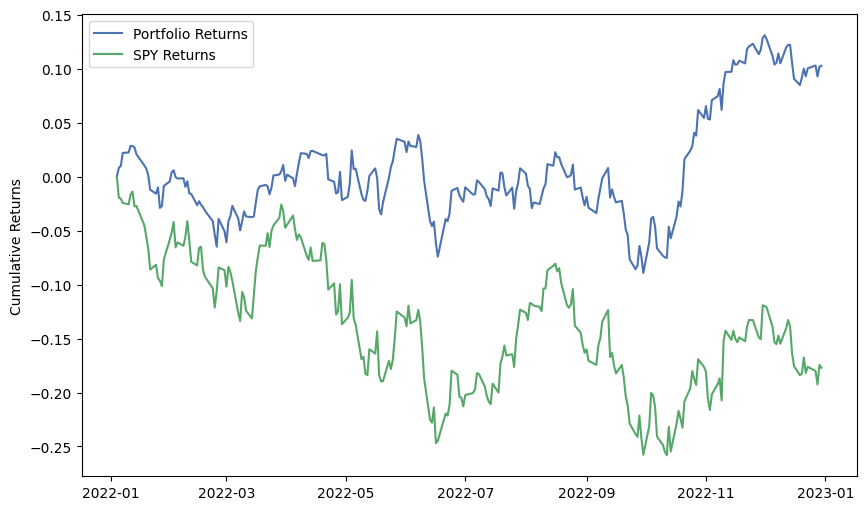

In [10]:
# Calculate portfolio and benchmark returns
portfolio_returns = portfolio_returns_1
benchmark_returns = spy_data.pct_change().dropna()

# Plot the returns
plt.figure(figsize=(10, 6), facecolor='none')
plt.plot(portfolio_returns.cumsum(), label='Portfolio Returns')
plt.plot(benchmark_returns.cumsum(), label='SPY Returns')
plt.legend()
#plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
#plt.title('Portfolio Returns vs SPY Returns')
# Remove background grid lines
plt.grid(visible=False)
plt.savefig('portfolio_vs_spy.png', transparent=True)

## Markowitz with Monthly Rebalancing keeping Original Weights Only

TODO

## Markowitz with Monthly Rebalancing - With Original Weights Revising every 12 months

TODO

# Hierarchical Risk Parity
HRP is a modern portfolio optimization method inspired by machine learning.

The idea is that by examining the hierarchical structure of the market, we can better diversify.

In [11]:
rets = expected_returns.returns_from_prices(historical_prices)

In [12]:
hrp = HRPOpt(rets)
hrp.optimize()
weights = hrp.clean_weights()
weights

OrderedDict([('AAPL', 0.03839),
             ('AMD', 0.00661),
             ('BA', 0.02589),
             ('BABA', 0.02056),
             ('BAC', 0.04636),
             ('GE', 0.04637),
             ('GM', 0.02526),
             ('GOOG', 0.02824),
             ('JPM', 0.05429),
             ('MU', 0.011),
             ('PFE', 0.15749),
             ('RRC', 0.03135),
             ('SBUX', 0.06785),
             ('T', 0.15349),
             ('UAA', 0.0223),
             ('WMT', 0.17271),
             ('XOM', 0.09184)])

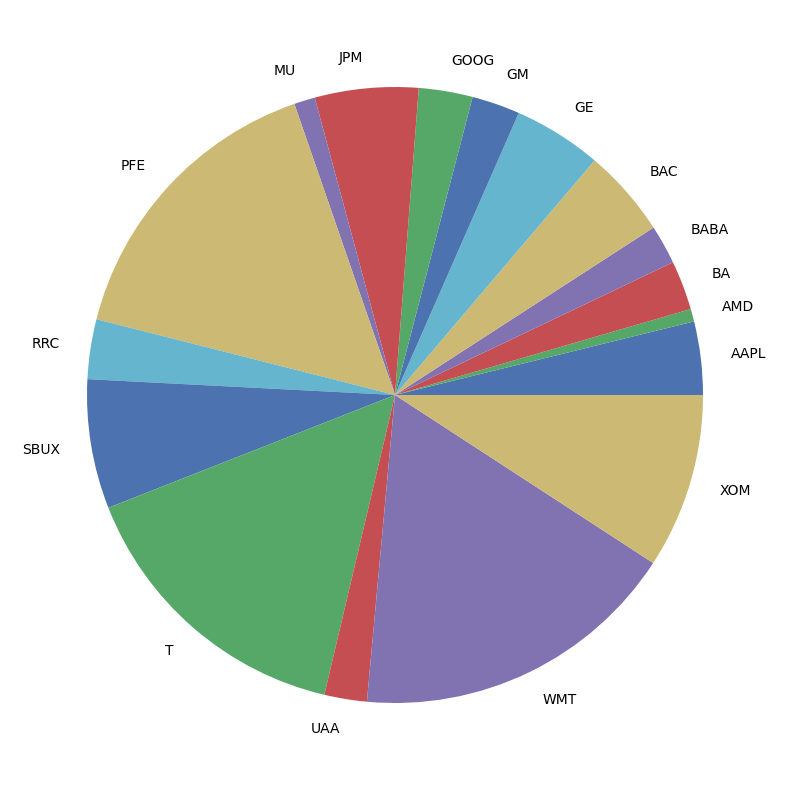

In [13]:
pd.Series(weights).plot.pie(figsize=(10, 10));

In [14]:
hrp.portfolio_performance(verbose=True);

Expected annual return: 0.2%
Annual volatility: 20.6%
Sharpe Ratio: -0.09


### Plotting

Plotting a dendrogram (tree diagram) based on the hierarchical structure of asset returns

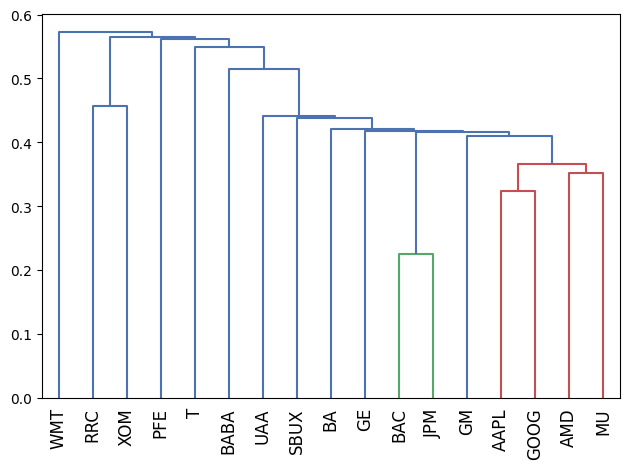

In [15]:
plotting.plot_dendrogram(hrp); 

## Simulation

#### Data Universe
Training Data start_date = '2022-01-01'

Training Data end_date = '2022-12-31'

Testing Data = 

In [16]:
print(end_date)

next_day = end_date + timedelta(days=1)

# We invest on the next day using cleaned_weights

print(next_day)

# Now we keep the target weights same for 1 year

next_year = end_date + relativedelta(years=1)

print(next_year)

2022-12-31
2023-01-01
2023-12-31


In [17]:
test_data = yf.download(tickers_list, start=next_day, end=next_year)['Adj Close']

[*********************100%***********************]  17 of 17 completed


In [18]:
testing_years = test_data.index.year.unique()
testing_months = test_data.index.month.unique()

print(testing_years, testing_months)

Index([2023], dtype='int32', name='Date') Index([1, 2, 3, 4, 5, 6, 7], dtype='int32', name='Date')


In [19]:
# Calculate the discrete allocation of assets based on the optimal weights
latest_prices = test_data.iloc[0]  # Latest prices for the assets - as on 3 Jan 2023
da = DiscreteAllocation(cleaned_weights, latest_prices, total_portfolio_value=10000)
old_allocation, leftover = da.lp_portfolio()

/home/bhavya/anaconda3/lib/python3.10/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


In [20]:
print("Optimal Allocation:", old_allocation)
print("Leftover:", leftover)
print (10000-leftover)

Optimal Allocation: {'BAC': 1, 'GE': 1, 'JPM': 9, 'PFE': 40, 'SBUX': 9, 'T': 112, 'WMT': 14, 'XOM': 17}
Leftover: 22.29282207962933
9977.70717792037


### Now we calculate the portfolio value after one month and effective weights after one month - which is ratio of current assets vs Portfolio Value

In [21]:
#find first trading day of the next month

current_month_prices = test_data[(test_data.index.year == 2023) & (test_data.index.month == 4)]

current_month_prices = current_month_prices.sort_index()

#pandas series with stocks name as index, prices are values and date as index name
first_trading_day_prices = current_month_prices.iloc[0]

In [22]:
#print(first_trading_day_prices)

In [23]:
print(old_allocation)

{'BAC': 1, 'GE': 1, 'JPM': 9, 'PFE': 40, 'SBUX': 9, 'T': 112, 'WMT': 14, 'XOM': 17}


In [24]:
#print(first_trading_day_prices)

In [25]:
# Current Value of Each stock in allocated portfolio
result = first_trading_day_prices * pd.Series(old_allocation)

print(result)

AAPL            NaN
AMD             NaN
BA              NaN
BABA            NaN
BAC       28.363667
GE        96.919998
GM              NaN
GOOG            NaN
JPM     1154.390076
MU              NaN
PFE     1636.293945
RRC             NaN
SBUX     938.974548
T       2103.801208
UAA             NaN
WMT     2073.782257
XOM     1957.226295
dtype: float64


In [26]:
new_portfolio_value = result.sum()

In [27]:
new_portfolio_value

9989.75199508667

In [28]:
current_effective_weights = result/new_portfolio_value

In [29]:
print(current_effective_weights)

AAPL         NaN
AMD          NaN
BA           NaN
BABA         NaN
BAC     0.002839
GE      0.009702
GM           NaN
GOOG         NaN
JPM     0.115557
MU           NaN
PFE     0.163797
RRC          NaN
SBUX    0.093994
T       0.210596
UAA          NaN
WMT     0.207591
XOM     0.195923
dtype: float64


In [30]:
print(cleaned_weights)

OrderedDict([('AAPL', 0.0), ('AMD', 0.0), ('BA', 0.00104), ('BABA', 0.0), ('BAC', 0.00486), ('GE', 0.00343), ('GM', 0.0), ('GOOG', 0.00436), ('JPM', 0.12335), ('MU', 0.0), ('PFE', 0.2), ('RRC', 0.0), ('SBUX', 0.08877), ('T', 0.2), ('UAA', 0.0), ('WMT', 0.2), ('XOM', 0.17419)])


### working optimization problem

In [31]:
import numpy as np
import cvxpy as cp
import collections
from pypfopt import exceptions
from pypfopt.discrete_allocation import DiscreteAllocation

class CustomDiscreteAllocation(DiscreteAllocation):
    def __init__(self, *args, min_value_constraints=None, **kwargs):
        super().__init__(*args, **kwargs)
        # Add any additional initialization code specific to your custom class
        self.min_value_constraints = min_value_constraints


    def lp_portfolio(self, reinvest=False, verbose=False, solver="GUROBI"):
        # Implement your custom logic here
        # Override the lp_portfolio method with your custom implementation
        # Add your desired logic here
        # Make sure to return the allocation and leftover variables as needed

        p = self.latest_prices.values
        n = len(p)
        w = np.fromiter([i[1] for i in self.weights], dtype=float)

        # Integer allocation
        # x will hold discrete allocation for all stocks
        x = cp.Variable(n, integer=True)
        # Remaining dollars
        r = self.total_portfolio_value - p.T @ x

        # Set up linear program
        eta = w * self.total_portfolio_value - cp.multiply(x, p)
        u = cp.Variable(n)
        constraints = [eta <= u, eta >= -u, x >= 0, r >= 0]
        
        # Add additional constraints to ensure certain elements of x are greater than their minimum values
        if self.min_value_constraints is not None:
            for ticker, min_value in self.min_value_constraints.items():
                constraints.append(x[ticker] >= min_value)

        objective = cp.sum(u) + r

        opt = cp.Problem(cp.Minimize(objective), constraints)

        if solver is not None and solver not in cp.installed_solvers():
            raise NameError("Solver {} is not installed. ".format(solver))
        opt.solve(solver=solver)

        if opt.status not in {"optimal", "optimal_inaccurate"}:  # pragma: no cover
            raise exceptions.OptimizationError("Please try greedy_portfolio")

        vals = np.rint(x.value).astype(int)
        self.allocation = self._remove_zero_positions(
            collections.OrderedDict(zip([i[0] for i in self.weights], vals))
        )

        if verbose:
            print("Funds remaining: {:.2f}".format(r.value))
            self._allocation_rmse_error()
        return self.allocation, r.value

In [32]:
total_portfolio_value = 10000

min_value_constraints = {
    0: 5, #Adding constraint to first element of the cleaned_weights
    # Add more ticker-value pairs as needed
}

#### Instantiate the CustomDiscreteAllocation class
da = CustomDiscreteAllocation(cleaned_weights, first_trading_day_prices, total_portfolio_value, min_value_constraints=min_value_constraints)

#### Customize the class as needed
da.max_allocation = 0.7

#### Call the lp_portfolio method with the additional constraint
new_allocation, leftover = da.lp_portfolio(reinvest=True, verbose=True)

#### Print the allocation and leftover value
print("Allocation:", new_allocation)
print("Leftover:", leftover)

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-22
Funds remaining: 0.02
AAPL: allocated 0.083, desired 0.000
AMD: allocated 0.000, desired 0.000
BA: allocated 0.000, desired 0.001
BABA: allocated 0.000, desired 0.000
BAC: allocated 0.003, desired 0.005
GE: allocated 0.000, desired 0.003
GM: allocated 0.000, desired 0.000
GOOG: allocated 0.000, desired 0.004
JPM: allocated 0.090, desired 0.123
MU: allocated 0.000, desired 0.000
PFE: allocated 0.184, desired 0.200
RRC: allocated 0.000, desired 0.000
SBUX: allocated 0.083, desired 0.089
T: allocated 0.192, desired 0.200
UAA: allocated 0.000, desired 0.000
WMT: allocated 0.193, desired 0.200
XOM: allocated 0.173, desired 0.174
Allocation has RMSE: 0.022
Allocation: {'AAPL': 5, 'BAC': 1, 'JPM': 7, 'PFE': 45, 'SBUX': 8, 'T': 102, 'WMT': 13, 'XOM': 15}
Leftover: 0.019130706787109375
